<a href="https://colab.research.google.com/github/sultanbst123/Image_augmentation_implementations/blob/main/Cutmix_%26_Mixup_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cutmix & Mixup Augmentation Implementation

## Library & File

In [ ]:
import os 
import random 
import numpy as np
import pandas as pd 

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seed()

In [ ]:

# load a cifar10 dataset

(x_train,y_train),(x_test, y_test)= tf.keras.datasets.cifar10.load_data()

In [ ]:

# nama label (target) 

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:

x_train = x_train.astype("float32") / 255.0 # [0, 1]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # one hot target 

x_test = x_test.astype("float32") / 255.0 [0, 1]
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10) # one hot target

In [ ]:

## define hyper parameter

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [ ]:

## data asli tanpa augmentation

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
) 

test_ds = ( 
     tf.data.Dataset.from_tensor_slices((x_test, y_test))    
     .batch(BATCH_SIZE)
)

print(train_ds) 
print(test_ds)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


Text(0.5, 1.0, 'Datasets without augmentation')

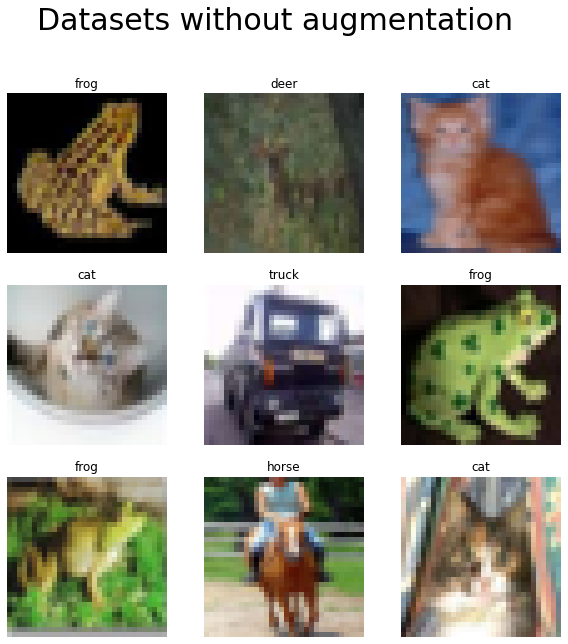

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.suptitle("Datasets without augmentation", y=1.0, size=30)

## Cutmix Implementation

In [ ]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
   # .batch(BATCH_SIZE)
    .prefetch(AUTO)
) 

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
  #  .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
# kombinasiakan 2 data "train_dw_one" dan "train_ds_two"

train_ds_combi = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [ ]:
##cutmix

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [ ]:
train_ds_cmu = (
    train_ds_combi.shuffle(1024)
    .map(cutmix,num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Text(0.5, 1.0, 'Cutmix')

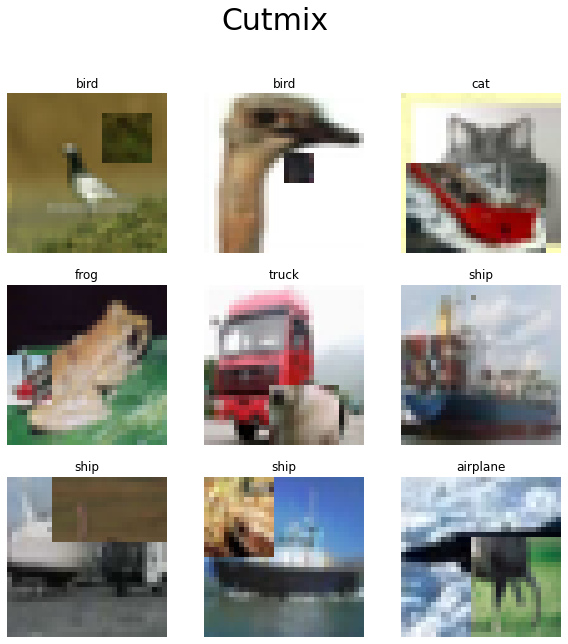

In [ ]:
image_batch, label_batch = next(iter(train_ds_cmu))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.suptitle("Cutmix", y=1.0,size=30)

##Mixup Implementation

In [ ]:

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
) 

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
# kombinasiakan 2 data "train_dw_one" dan "train_ds_two"

train_ds_combi = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [ ]:
## Mixup

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
train_ds_mu = (
    train_ds_combi.shuffle(1024)
    .map(mix_up, num_parallel_calls=AUTO)
    #.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Text(0.5, 1.0, 'Mixup')

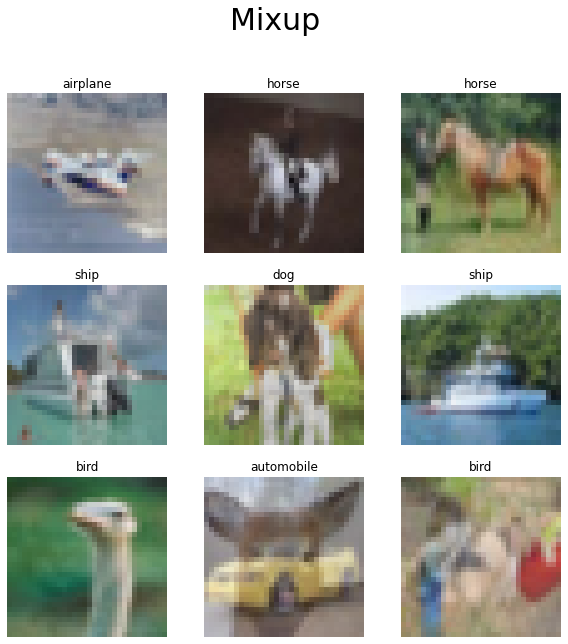

In [ ]:
image_batch, label_batch = next(iter(train_ds_mu))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.suptitle("Mixup", y=1.0, size=30)